# Generate training dataset of noughts and crosses (Tic-tac-toe) images.

In [129]:
import numpy as np
from skimage.morphology import selem
from skimage import measure
from PIL import Image
from matplotlib import pyplot as plt
import random
import json
import os

In [130]:
def define_table_params(grid_size_range, char_size_range, linewidth_range):
    """ 
        From predefined range, choose randomly and adjust the following table parameters:
        grid size, char size, char position and linewidth.
    """

    grid_size = random.choice(grid_size_range)
    linewidth = random.choice(linewidth_range)

    if grid_size%3 != 0:
        grid_size = (grid_size+1) if (grid_size+1)%3 == 0 else (grid_size+2)
    cell_size = int(grid_size/3)

    char_size = random.choice(char_size_range[np.where(char_size_range < (cell_size-linewidth))][:-1])

    spacing = cell_size-char_size
    split_bound = random.randint(2, spacing-2)
    first_char_pos = (split_bound, split_bound+char_size)

    chars_pos = [((r*cell_size+first_char_pos[0], r*cell_size+first_char_pos[1],
                  c*cell_size+first_char_pos[0], c*cell_size+first_char_pos[1]), (r,c))
                 for r in range(0,3) for c in range(0,3)]
    
    return grid_size, char_size, chars_pos, linewidth, cell_size

In [131]:
def create_circle(radius=15, linewidth=2):
    """ Create a nought with a specific radius and linewidth. """

    circle_large = selem.ellipse(radius, radius)
    circle_small = np.pad(selem.ellipse(radius-linewidth, radius-linewidth), linewidth, mode="constant")
    return 1 - (circle_large - circle_small)

In [132]:
def create_cross(size=31, linewidth=2):
    """ Create a cross with a specific size and linewidth. """

    cross = np.zeros([size, size])
    for i in range(size):
        cross[i:i+linewidth, i:i+linewidth] = 1
        cross[(size-i-linewidth):(size-i), i:i+linewidth] = 1
    return 1 - cross

In [133]:
def create_grid(size=120):
    """ Create 3x3 regular grid. """

    grid = np.ones([size, size])
    subgrid_size = int(size/3)
    grid[subgrid_size:subgrid_size+1, :] = 0
    grid[2*subgrid_size:2*subgrid_size+1, :] = 0
    grid[:, subgrid_size:subgrid_size+1] = 0
    grid[:, 2*subgrid_size:2*subgrid_size+1] = 0
    
    return grid

In [134]:
def make_chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [135]:
def fill_grid(grid, cross, circle, chars_pos, naught_and_cross):
    """ Fill the grid with noughts and crosses. """

    chars = []
    img = grid.copy()
    for cell, pos in enumerate(chars_pos):
        char = random.choice(["x", "o"])
        chars.append((char, pos[1]))
        obj = naught_and_cross[char]
        img[pos[0][0]:pos[0][1], pos[0][2]:pos[0][3]] = obj

    return (255*img).astype("uint8"), chars

In [136]:
def create_mask(grid, chars, cell_size):
    mask = np.zeros(grid.shape, dtype='uint8')
    chunks = list(make_chunks(chars, 3))
    for row, chunk in enumerate(chunks):
        for col, char in enumerate(chunk):
            if char[0] == "x":
                mask[row*cell_size:row*cell_size+cell_size, col*cell_size:col*cell_size+cell_size] = 255
    return mask.astype('uint8')

In [140]:
def generate_images(number, grid_size_range, char_size_range, linewidth_range, save=True, path="datasets/tictactoe"):
    """ Generate images of naught and cross grid. """
    
    if not os.path.exists(path):
        os.mkdir(path)
    img_path = os.path.join(path, "image_train")
    mask_path = os.path.join(path, "mask_train")
    char_path = os.path.join(path, "char_train")
    if not os.path.exists(img_path):
        os.mkdir(img_path)
    if not os.path.exists(mask_path):
        os.mkdir(mask_path)
    if not os.path.exists(char_path):
        os.mkdir(char_path)
    
    make_path = lambda path, i, extension: os.path.join(path, "tictactoe_" + str(i) + extension)
    all_imgs = []
    all_masks = []
    all_chars = []
    for i in range(number):
        grid_size, char_size, chars_pos, linewidth, cell_size = define_table_params(grid_size_range, char_size_range, linewidth_range)
        cross = create_cross(size=char_size, linewidth=linewidth)
        circle = create_circle(radius=int((char_size-1)/2), linewidth=linewidth)
        naught_and_cross = {"x": cross, "o": circle}
        grid = create_grid(grid_size)
        img, chars = fill_grid(grid, cross, circle, chars_pos, naught_and_cross)
        mask = create_mask(grid, chars, cell_size)
        all_imgs.append(img)
        all_masks.append(mask)
        all_chars.append(chars)
        if save:
            Image.fromarray(img).save(make_path(img_path, i, ".png"))
            Image.fromarray(mask).save(make_path(mask_path, i, ".png"))
            with open(make_path(char_path, i, ".json"), "w") as f:
                json.dump(chars, f)
        
    return all_imgs, all_masks, all_chars

### Set table parameters

In [141]:
# grid size
grid_size_range = np.arange(90, 230, 3)
# char size
char_size_range = np.arange(15, 65, 2)
# border linewidth
linewidth_range = np.arange(1,5,1)

### Create train test

In [142]:
imgs, masks, chars = generate_images(3, grid_size_range, char_size_range, linewidth_range, save=True)

### Plot example images

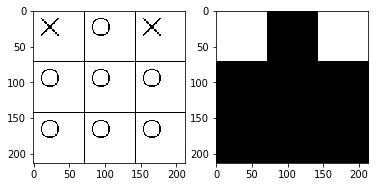

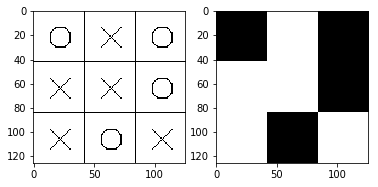

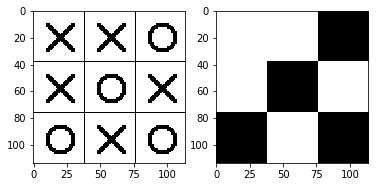

In [114]:
for img, mask in zip(imgs, masks):
    plt.subplot(1,2,1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap=plt.cm.gray)
    #print(text)
    plt.show()